In [0]:
!wget https://download.pytorch.org/tutorial/data.zip

--2019-07-28 05:18:55--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.15.32, 13.226.15.53, 13.226.15.43, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.15.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  16.6MB/s    in 0.2s    

2019-07-28 05:18:55 (16.6 MB/s) - ‘data.zip.1’ saved [2882130/2882130]



In [0]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

import unicodedata
import string
import math

In [0]:
def findFiles(path): return glob.glob(path)


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [0]:
category_lines = {}
train_data = {}
test_data = {}
all_categories = []


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8 * len(lines)))]
    test_data[category] = lines[int(math.floor(0.8 * len(lines))) + 1:]
    category_lines[category] = lines

n_categories = len(all_categories)

In [0]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, model="linear", n_layers=1):
    super(RNN, self).__init__()
    self.model = model.lower()
    self.hidden_size = hidden_size
    self.n_layers = n_layers


    if self.model == "gru":
      self.rnn = nn.GRU(input_size, hidden_size, n_layers)
      self.decoder = nn.Linear(hidden_size, output_size)
    elif self.model == "lstm":
      self.rnn = nn.LSTM(input_size, hidden_size, n_layers)
      self.decoder = nn.Linear(hidden_size, output_size)
    else:
      self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
      self.i2o = nn.Linear(input_size + hidden_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    
    if self.model == 'gru' or self.model == 'lstm':
      output, hidden = self.rnn(input.view(1, 1, -1), hidden)
      output = self.decoder(output.view(1, -1))
      output = self.softmax(output)
      return output, hidden
    else:
      combined = torch.cat((input, hidden), 1)
      hidden = self.i2h(combined)
      output = self.i2o(combined)
      output = self.softmax(output)
      return output, hidden

  def initHidden(self, batch_size):
    if self.model == "lstm":
      return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
    elif self.model == "gru":
      return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
    else:
      return torch.zeros(1, self.hidden_size)

In [0]:
import random
import time
import math

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor  

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden(1)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.005  # If you set this too high, it might explode. If too low, it might not learn


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(1)
#     print(hidden.shape)

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
#         print(hidden.shape)
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [0]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories, 'lstm')

start = time.time()

# Keep track of losses for plotting
n_iters = 100000
print_every = 5000
plot_every = 1000 

current_lstm_loss = 0
all_lstm_losses = []
all_lstm_test_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_lstm_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print(
            '%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_lstm_losses.append(current_lstm_loss / plot_every)
        current_lstm_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_lstm_test_losses.append(test_loss.item() / n_test_instances)

5000 5% (0m 41s) 2.8728 Kerr / English âœ— (Scottish)
10000 10% (1m 28s) 2.8538 Smolak / English âœ— (Polish)
15000 15% (2m 16s) 2.6226 Kouches / Greek âœ“
20000 20% (3m 4s) 2.9468 Colbert / Dutch âœ— (French)
25000 25% (3m 52s) 1.9941 Xuan / Korean âœ— (Chinese)
30000 30% (4m 40s) 0.9015 Mersinias / Greek âœ“
35000 35% (5m 28s) 2.4780 Petit / Arabic âœ— (French)
40000 40% (6m 16s) 2.0167 Bonaventura / Spanish âœ“
45000 45% (7m 5s) 1.2322 Ku / Chinese âœ— (Korean)
50000 50% (7m 53s) 2.0480 Sauvageot / Irish âœ— (French)
55000 55% (8m 40s) 2.0720 Sutherland / Irish âœ— (Scottish)
60000 60% (9m 28s) 2.0013 Trollope / Czech âœ— (English)
65000 65% (10m 16s) 3.2047 Eastaway / Arabic âœ— (English)
70000 70% (11m 4s) 0.6185 Sowka / Polish âœ“
75000 75% (11m 52s) 1.5839 Gaber / French âœ— (Arabic)
80000 80% (12m 40s) 0.0797 Kajahara / Japanese âœ“
85000 85% (13m 29s) 2.6326 Foster / German âœ— (English)
90000 90% (14m 17s) 1.5875 Hor / Korean âœ— (Chinese)
95000 95% (15m 5s) 0.9740 Motoori / 

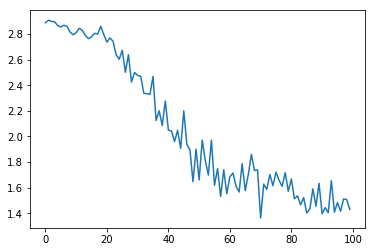

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_lstm_test_losses)

In [0]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories, 'gru')

start = time.time()

# Keep track of losses for plotting
n_iters = 100000
print_every = 5000
plot_every = 1000 

current_gru_loss = 0
all_gru_losses = []
all_gru_test_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_gru_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print(
            '%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_gru_losses.append(current_gru_loss / plot_every)
        current_gru_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_gru_test_losses.append(test_loss.item() / n_test_instances)

5000 5% (0m 38s) 2.7354 Sonnen / German âœ“
10000 10% (1m 22s) 2.6803 Yau / Chinese âœ“
15000 15% (2m 6s) 2.3456 Battaglia / Czech âœ— (Italian)
20000 20% (2m 51s) 2.4423 Mendez / German âœ— (Spanish)
25000 25% (3m 35s) 1.7785 Baumgartner / Dutch âœ— (German)
30000 30% (4m 20s) 1.4633 Ra / Vietnamese âœ— (Korean)
35000 35% (5m 4s) 1.3052 Senft / German âœ“
40000 40% (5m 49s) 2.6230 Klineberg / Dutch âœ— (Czech)
45000 45% (6m 34s) 1.0232 Dou / Korean âœ— (Chinese)
50000 50% (7m 19s) 4.6409 Roig / Korean âœ— (Spanish)
55000 55% (8m 3s) 1.1886 Albuquerque / French âœ— (Portuguese)
60000 60% (8m 48s) 1.3549 Drago / Portuguese âœ— (Italian)
65000 65% (9m 32s) 1.4470 Malley / Irish âœ— (English)
70000 70% (10m 16s) 0.9852 Xiao / Chinese âœ“
75000 75% (11m 1s) 1.1533 Touma / Japanese âœ— (Arabic)
80000 80% (11m 46s) 0.1457 Demarchis / Greek âœ“
85000 85% (12m 30s) 0.5685 Touma / Arabic âœ“
90000 90% (13m 15s) 0.0963 Yoo / Korean âœ“
95000 95% (14m 0s) 2.0056 Vodden / Dutch âœ— (English)
10000

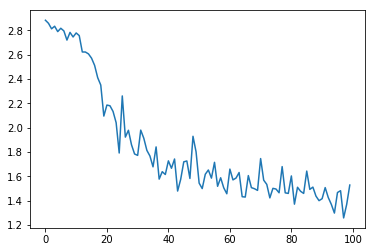

In [0]:
plt.figure()
plt.plot(all_gru_test_losses)

In [0]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

start = time.time()

# Keep track of losses for plotting
n_iters = 100000
print_every = 5000
plot_every = 1000 

current_loss = 0
all_losses = []
all_test_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'âœ“' if guess == category else 'âœ— (%s)' % category
        print(
            '%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)

5000 5% (0m 14s) 2.7121 Krauss / Portuguese âœ— (German)
10000 10% (0m 30s) 4.9621 Shel / Chinese âœ— (Russian)
15000 15% (0m 46s) 2.5295 Adamou / Russian âœ— (Greek)
20000 20% (1m 2s) 2.7385 Poulin / Irish âœ— (French)
25000 25% (1m 18s) 2.0554 Souza / Czech âœ— (Portuguese)
30000 30% (1m 34s) 1.6030 Rome / French âœ“
35000 35% (1m 50s) 0.0407 Kawasawa / Japanese âœ“
40000 40% (2m 6s) 2.9351 Ross / Greek âœ— (Scottish)
45000 45% (2m 22s) 1.0973 Gaber / Arabic âœ“
50000 50% (2m 38s) 1.3097 Del olmo / Italian âœ— (Spanish)
55000 55% (2m 54s) 0.2065 Nakhodkin / Russian âœ“
60000 60% (3m 11s) 1.3131 Johnston / Scottish âœ“
65000 65% (3m 27s) 3.5788 Maas / Chinese âœ— (Dutch)
70000 70% (3m 43s) 1.5563 Novy Novy / English âœ— (Czech)
75000 75% (3m 59s) 0.1259 Mcdonald / Scottish âœ“
80000 80% (4m 15s) 0.3183 Luc / Vietnamese âœ“
85000 85% (4m 31s) 0.3939 Vuong / Vietnamese âœ“
90000 90% (4m 47s) 1.5119 Traverse / Greek âœ— (French)
95000 95% (5m 3s) 1.4056 Duncan / Irish âœ— (Scottish)
1000

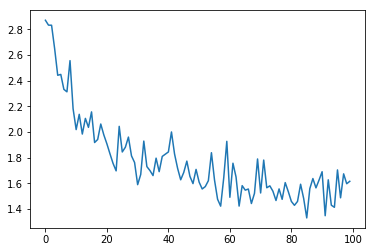

In [0]:
plt.figure()
plt.plot(all_test_losses)

<Figure size 432x288 with 0 Axes>

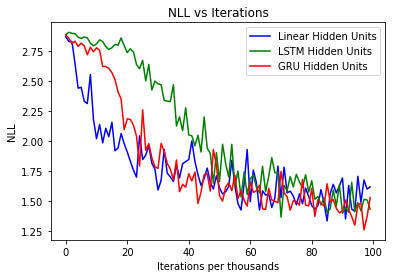

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(all_test_losses,'b',label='Linear Hidden Units')
plt.plot(all_lstm_test_losses,'g',label='LSTM Hidden Units')
plt.plot(all_gru_test_losses,'r',label='GRU Hidden Units')

plt.title('NLL vs Iterations')
plt.xlabel("Iterations per thousands")
plt.ylabel("NLL")
plt.legend()
plt.savefig("hidden_units_graph.png")
plt.figure()
